In [1]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
s_time=time.time()

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save_200_1e-2.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save_200_1e-2.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
e_time=time.time()
td=e_time-s_time
print('Model time difference is %s seconds:' %(td))


<ipython-input-3-ba86f2dd624d>:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Streaming output truncated to the last 5000 lines.
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
ep 949: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.013376219509276
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: 1.0 !!!!!!!!
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: 1.0 !!!!!!!!
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, reward: -1.0
ep 950: game finished, r

In [4]:
seconds = td % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 0 hours 59 minutes 34 seconds


In [5]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [6]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [7]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [8]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

<ipython-input-3-ba86f2dd624d>:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = -15.0


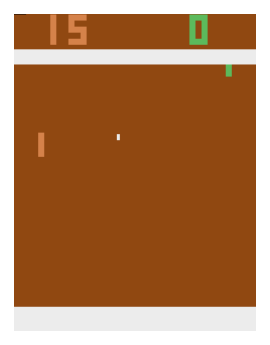

In [9]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)